# IFT 6758 - Devoir 3 

### Pt 1. Reddit Weekends

Évaluation pour ce notebook:

- Histogrammes pour les counts de base, les counts transformés, et les counts du théorème limite central
- Réponses courtes (dernière section)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
from datetime import date
import scipy.stats as sp

In [4]:
import reddit_weekends

## 1. Charger les données

Lire les données JSON et filtrer/nettoyer le dataframe

In [5]:
raw_df = reddit_weekends.read_data("data/reddit-counts.json.gz")

In [6]:
raw_df.head()

,date,subreddit,comment_count
0,2012-02-20,newfoundland,7
1,2015-01-26,Manitoba,1
2,2013-09-07,Yukon,2
3,2014-02-15,saskatchewan,5
4,2014-07-06,canada,1652


In [7]:
# TODO: Complétez ces implémentations dans reddit_weekends.py
df = reddit_weekends.process_data(raw_df)
wd, we = reddit_weekends.split_data(df)

### T-Test

In [8]:
# TODO: Complétez ces implémentations dans reddit_weekends.py
p_ttest, p_wdNormal, p_weNormal, p_vartest = reddit_weekends.tests(wd, we, verbose=True)

p_value:	0.0
WD normality:	0.0
WE normality:	0.00152
Variance test:	0.04379


### Solution 1: transformer les données pourrait nous aider

Jetez un oeil à l'histogramme des données. Vous remarquerez qu'il est biaisé: c'est la raison pour laquelle il n'a pas été distribué normalement dans la dernière partie. Essayez de transformer les décomptes afin que les données n'échouent pas au test de normalité. Considérez les transformations suivantes :

     np.log, np.exp, np.sqrt, counts**2
    
Pour chaque transformation, tracez le nouvel histogramme (`reddit_weekends.draw_histogram()`) et exécutez la méthode `reddit_weekends.tests()` pour voir si vous pouvez maintenant utiliser le test T.
    
Remarque: aucune d'entre elles ne fera passer le test de normalité aux deux distributions. Le mieux que vous pouvez obtenir est une variable avec des problèmes de normalité, une bonne; pas de problèmes de variance égale.

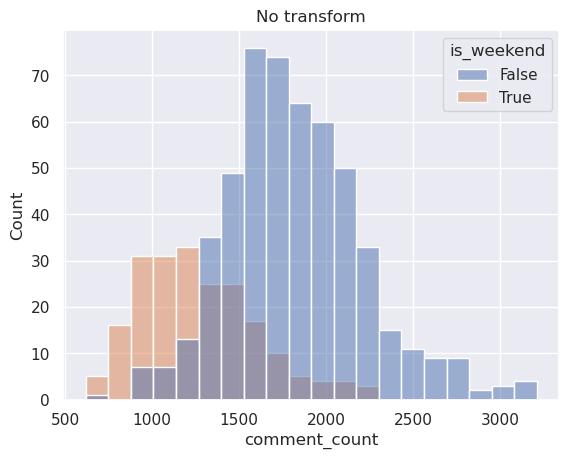

In [9]:
fig = reddit_weekends.draw_histogram(df, title="No transform")

-- Tests for log transform --
p_value:	0.0
WD normality:	0.0004
WE normality:	0.31494
Variance test:	0.00042


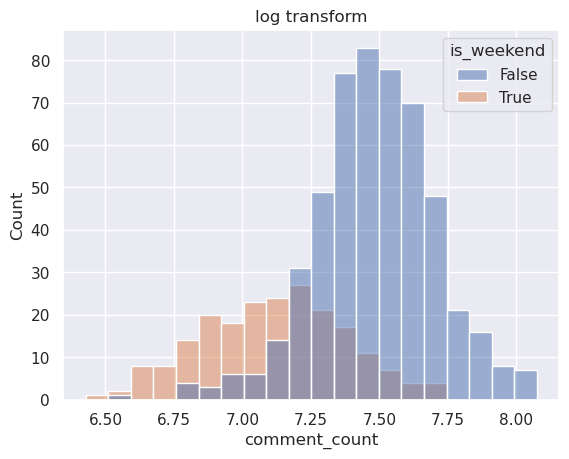

In [15]:
# TODO: Appliquez les transformations aux données copiées (ne modifiez pas le dataframe original!)
# TODO: Tracez l'histogramme
# TODO: Exécutez les tests à nouveau
tmp_df = df.copy()
tmp_df['comment_count'] = tmp_df['comment_count'].apply(np.log)
reddit_weekends.draw_histogram(tmp_df, title="log transform")
print("-- Tests for log transform --")
_wd, _we = reddit_weekends.split_data(tmp_df)
_ = reddit_weekends.tests(_wd, _we, verbose=True)
plt.show()

/home/mohamed/miniconda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/mohamed/miniconda/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1177: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/home/mohamed/miniconda/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/mohamed/miniconda/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mohamed/miniconda/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Valeurs uniques de 'is_weekend' : [ True]
-- Tests pour la transformation exponentielle --
Erreur lors des tests : skewtest is not valid with less than 8 samples; 0 samples were given.


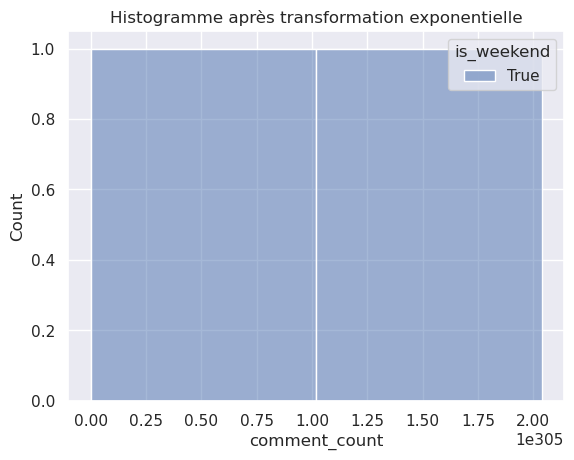

In [27]:
# TODO: RÉPÉTEZ POUR LES AUTRES TRANSFORMATIONS
tmp_df = df.copy()
tmp_df['comment_count'] = np.exp(tmp_df['comment_count'])
tmp_df = tmp_df[np.isfinite(tmp_df['comment_count'])]
assert 'is_weekend' in tmp_df.columns, "Erreur : la colonne 'is_weekend' est absente."
print(f"Valeurs uniques de 'is_weekend' : {tmp_df['is_weekend'].unique()}")
reddit_weekends.draw_histogram(tmp_df, title="Histogramme après transformation exponentielle")
print("-- Tests pour la transformation exponentielle --")
try:
    _wd, _we = reddit_weekends.split_data(tmp_df)
    _ = reddit_weekends.tests(_wd, _we, verbose=True)
except ValueError as e:
    print(f"Erreur lors des tests : {e}")
plt.show()


-- Tests for sqrt transform --
p_value:	0.0
WD normality:	0.03687
WE normality:	0.10761
Variance test:	0.55605


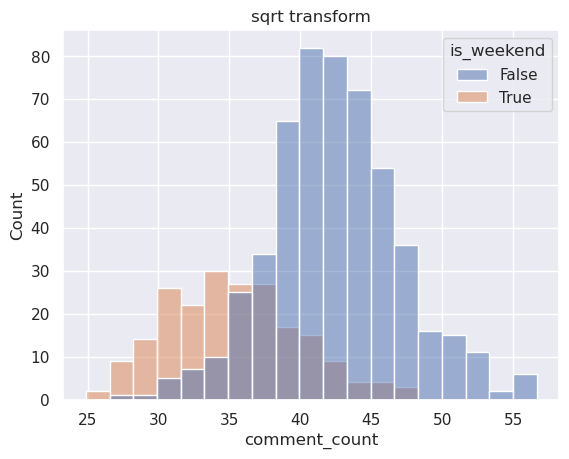

In [28]:
tmp_df = df.copy()
tmp_df['comment_count'] = np.sqrt(tmp_df['comment_count'])
reddit_weekends.draw_histogram(tmp_df, title="sqrt transform")
print("-- Tests for sqrt transform --")
_wd, _we = reddit_weekends.split_data(tmp_df)
_ = reddit_weekends.tests(_wd, _we, verbose=True)
plt.show()

-- Tests for power2 transform --
p_value:	0.0
WD normality:	0.0
WE normality:	0.0
Variance test:	0.0


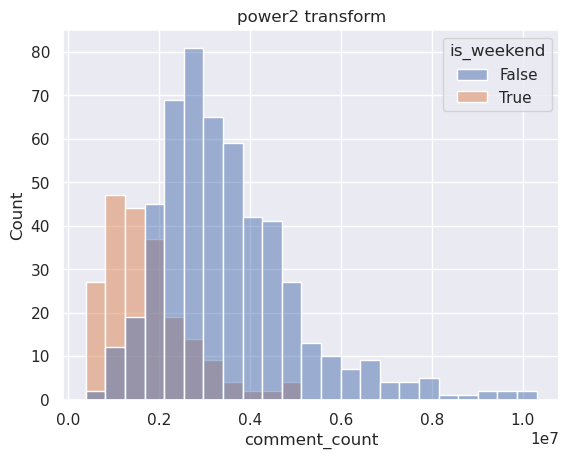

In [29]:
tmp_df = df.copy()
tmp_df['comment_count'] = tmp_df['comment_count']**2
reddit_weekends.draw_histogram(tmp_df, title="power2 transform")
print("-- Tests for power2 transform --")
_wd, _we = reddit_weekends.split_data(tmp_df)
_ = reddit_weekends.tests(_wd, _we, verbose=True)
plt.show()

# Correction 2: le théorème central limite pourrait nous sauver.

Le théorème central limite dit que si nos nombres sont suffisamment grands et que nous examinons les moyennes de l'échantillon, alors le résultat devrait être normal.
Essayons cela: nous combinerons tous les jours de semaine et de week-end de chaque paire année/semaine et prendrons la moyenne de leurs décomptes (non transformés).

Astuces: vous pouvez obtenir une "année" et un "numéro de semaine" à partir des deux premières valeurs renvoyées par date.isocalendar(). Cette année et ce numéro de semaine vous donneront un identifiant pour la semaine. Utilisez Pandas pour regrouper par cette valeur et agréger en prenant la moyenne. 

Remarque: l'année renvoyée par isocalendar n'est pas toujours la même que l'année de la date (autour de la nouvelle année). Utilisez l'année de l'isocalendar qui est correcte dans ce cas.

Vérifiez ces valeurs pour la normalité et la variance égale. Appliquez un test T si cela a du sens. (Indice : youpi !)

Nous devrions noter que nous modifions subtilement la question ici. La nouvelle questions ressemble plutôt à "le nombre de commentaires le week-end diffère-t-il du nombre de commentaires les jours de semaine pour chaque semaine?"

In [20]:
# TODO: Complétez ces implémentations dans reddit_weekends.py
clt = reddit_weekends.central_limit_theorem(df)
clt.head()

,year,week,is_weekend,comment_count
0,2011,52,True,995.0
1,2012,1,False,1561.6
2,2012,1,True,1163.0
3,2012,2,False,2062.8
4,2012,2,True,1372.0


p_value:	0.0
WD normality:	0.30826
WE normality:	0.15295
Variance test:	0.20384


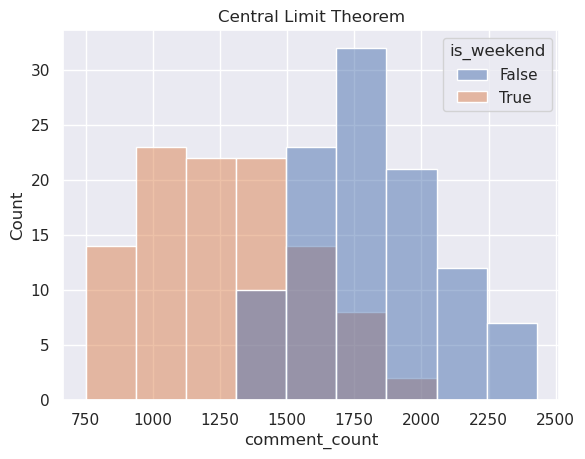

In [21]:
reddit_weekends.draw_histogram(clt, "Central Limit Theorem")

_wd, _we = reddit_weekends.split_data(clt)
_ = reddit_weekends.tests(_wd, _we, verbose=True)

## Correction 3: un test non paramétrique pourrait nous sauver.

L'autre option que nous avons dans notre boîte à outils : un test statistique qui ne se soucie pas autant de la forme de son entrée. Le test U de Mann – Whitney ne suppose pas de valeurs distribuées normalement ni de variance égale.

Effectuez un test U sur les décomptes (initiaux non transformés, non agrégés). Notez que nous devrions faire ici un test bilatéral, qui correspondra aux autres analyses. Assurez-vous que les arguments de la fonction sont corrects.

Encore une fois, notez que nous modifions subtilement la question à nouveau. Si nous parvenons à une conclusion à cause d'un test U, c'est quelque chose comme "il n'est pas également probable qu'il y a un plus grand nombre de commentaires le week-end par rapport aux jours de semaine".

In [22]:
# TODO: Complétez ces implémentations dans reddit_weekends.py
p_utest = reddit_weekends.mann_whitney_u_test(wd, we)
print(f"Mann-Whitney U-test p-value: {p_utest}")

Mann-Whitney U-test p-value: 8.6244532347343e-53


# Réponses courtes

1. Laquelle des quatre transformations suggérées vous rapproche le plus de satisfaire les hypothèses d'un test T ?

*Votre Réponse*


2. J'ai donné des explications imprécises en mots de ce que le test hebdomadaire et le test de Mann-Whitney testaient réellement.
    Faites de même pour le test T d'origine et pour le test T des données transformées.
    Autrement dit, décrivez quelle serait la conclusion si vous pouviez rejeter l'hypothèse nulle dans ces tests.

*Votre Réponse*


3. Parmi les quatre approches, laquelle, selon vous, réussit le mieux à obtenir une réponse à la question initiale : "y a-t-il un nombre différent de commentaires Reddit publiés en semaine et le week-end ?"
    Expliquez brièvement pourquoi. (Il n'est pas clair qu'il y ait une seule réponse correcte à cette question, mais il y en a de mauvaises !)

*Votre Réponse*


4. En moyenne, sur Reddit /r/canada, en moyenne: est-ce qu'il y a plus de commentaires publiés en semaine ou le week-end ?

*Ta Réponse*